## 1. Load Dataset into Memory

In [1]:
import pandas as pd
from sklearn import preprocessing
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
file_path = 'C:\\Users\\MRT\\OneDrive\\Documents\\MastersDs\\DeepLearning\\Projects\\Womens_Clothing_E-Commerce_Reviews.csv'
reviews = pd.read_csv(file_path)

In [3]:
reviews.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
reviews.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [5]:
del reviews['Unnamed: 0']

In [6]:
reviews.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

## 2. Concatenate the Title, Review Text, Division Name, Department Name, and Class Name as a new feature of Reviews.

In [7]:
reviews['Title'] = reviews['Title'].fillna('')
reviews['Review Text'] = reviews['Review Text'].fillna('')
reviews['Division Name'] = reviews['Division Name'].fillna('')
reviews['Department Name'] = reviews['Department Name'].fillna('')
reviews['Class Name'] = reviews['Class Name'].fillna('')

In [8]:
reviews['Review'] = reviews[['Title', 'Review Text', 'Division Name', 'Department Name',
                               'Class Name']].apply(' '.join, axis=1)
reviews.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'Review'],
      dtype='object')

In [9]:
drop_columns = ['Title', 'Review Text', 'Division Name', 'Department Name', 'Class Name']

reviews = reviews.drop(drop_columns, axis=1)

In [10]:
reviews.columns

Index(['Clothing ID', 'Age', 'Rating', 'Recommended IND',
       'Positive Feedback Count', 'Review'],
      dtype='object')

## 3. Clean the new feature of reviews using regular expressions

In [11]:
# Remove all special characters, punctuation and spaces
reviews['Review'] = reviews['Review'].apply(lambda x: re.sub(r'[^A-Za-z0-9]+',' ',x))
# Replace special characters,<br />,  in the file
reviews['Review'] = reviews['Review'].apply(lambda x: re.sub(r"<br />", " ", x))
# Remove length <=2
reviews['Review'] = reviews['Review'].apply(lambda x: re.sub(r'\b[a-zA-Z]{1,2}\b', '', x))

In [12]:
reviews.head()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count,Review
0,767,33,4,1,0,Absolutely wonderful silky and sexy and comfo...
1,1080,34,5,1,4,Love this dress sooo pretty happened find...
2,1077,60,3,0,0,Some major design flaws had such high hopes f...
3,1049,50,5,1,0,favorite buy love love love this jumpsuit ...
4,847,47,5,1,6,Flattering shirt This shirt very flattering ...


## 4. Build an RNN model to forecast the Recommended IND based on Reviews using TensorFlow

In [13]:
X = reviews['Review'].values
y = reviews['Recommended IND'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [14]:
print(f'X_train size  ={X_train.shape}; X_test size  ={X_test.shape}')

X_train size  =(18788,); X_test size  =(4698,)


In [15]:
# Specify the vocab size
VOCAB_SIZE = 1000
# Perform textvectorization
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Fits the state of the preprocessing layer to the dataset.
encoder.adapt(X_train)

In [16]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'this', 'general', 'but', 'for',
       'dresses', 'with', 'was', 'dress', 'tops', 'love', 'not', 'petite',
       'that', 'size', 'very', 'top'], dtype='<U13')

In [17]:
model = tf.keras.Sequential([
    # Convert review text to indices
    encoder, 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=65,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    # 
    tf.keras.layers.GRU(130, return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    # Binary classifier
    tf.keras.layers.Dense(65, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [19]:
%%time
history = model.fit(x=X_train,y=y_train,batch_size= 32,epochs=5,
          validation_data=(X_test,y_test), verbose= 1
          )

Epoch 1/5
588/588 [==============================] - 304s 462ms/step - loss: 0.3499 - accuracy: 0.8075 - val_loss: 0.2376 - val_accuracy: 0.8936
Epoch 2/5
588/588 [==============================] - 261s 444ms/step - loss: 0.2097 - accuracy: 0.9099 - val_loss: 0.2219 - val_accuracy: 0.8985
Epoch 3/5
588/588 [==============================] - 268s 456ms/step - loss: 0.1940 - accuracy: 0.9182 - val_loss: 0.2251 - val_accuracy: 0.8957
Epoch 4/5
588/588 [==============================] - 259s 441ms/step - loss: 0.1881 - accuracy: 0.9201 - val_loss: 0.2232 - val_accuracy: 0.9051
Epoch 5/5
588/588 [==============================] - 264s 449ms/step - loss: 0.1843 - accuracy: 0.9217 - val_loss: 0.2273 - val_accuracy: 0.9044
CPU times: total: 2h 12min 56s
Wall time: 22min 36s


## 5. Evaluate the model and check the model fit

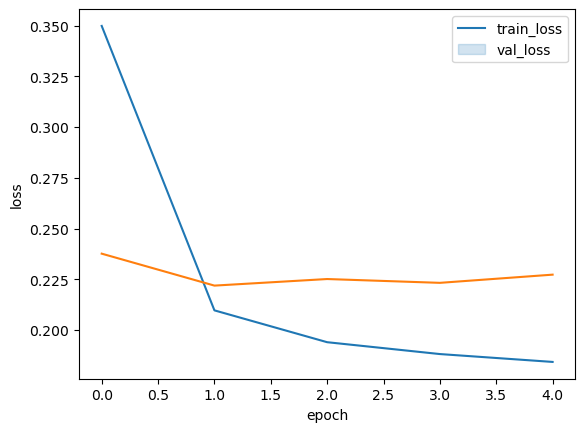

In [20]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

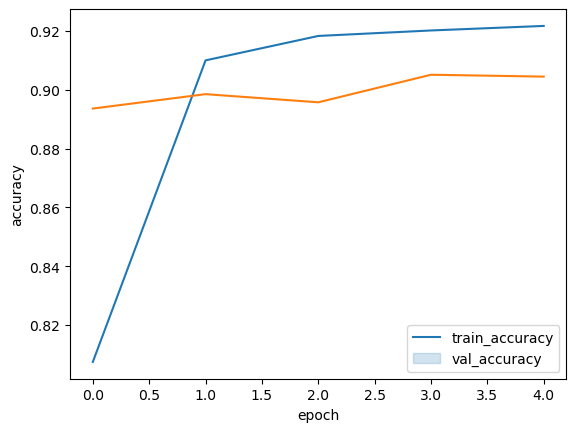

In [21]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [22]:
# the cutoff probability is 50%
y_pred = (model.predict(X_test)> 0.5).astype(int)

147/147 [==============================] - 30s 119ms/step


In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[ 623,  212],
       [ 237, 3626]], dtype=int64)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.75      0.74       835
           1       0.94      0.94      0.94      3863

    accuracy                           0.90      4698
   macro avg       0.83      0.84      0.84      4698
weighted avg       0.91      0.90      0.90      4698



In [25]:
reviews['Recommended IND'].value_counts()

1    19314
0     4172
Name: Recommended IND, dtype: int64

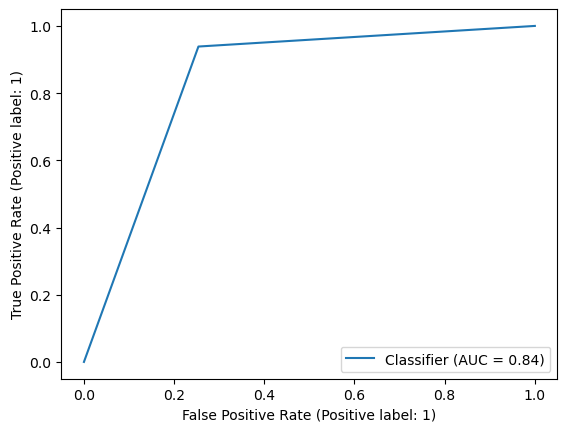

In [26]:
from sklearn.metrics import RocCurveDisplay
rnn_disp = RocCurveDisplay.from_predictions(y_test, y_pred, pos_label =1)

## Do you recommend this model?
No I do not recommend this model as it does not learn the data enough, this can be seen from the RocCurve and the precision, recall, and f1 score of the Recommended IND of class 0. This could be as a result of the dataset being imbalanced as well.